<img src="./all-models.jpg" alt="drawing" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_gbq

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

import fbprophet

import ArapFunctions as ar

In [3]:
sql_query = """
SELECT 
  asin,
  product_title,
  category,
  subcategory,
  shipped_units,
  rep_oos,
  subcategory_sales_rank,
  change_in_gv_prior_period,
  start_date,
  end_date, 
  country
    
FROM 
  `cp-gaa-visualization-dev.arap.sales_diagnostic_detail_dly`
  
WHERE
  product_title LIKE "%Softsoap%" AND product_title LIKE "%Liquid Hand Soap%" 
  AND
  country = 'USA'
  AND 
  (start_date >= '2019-10-01' AND end_date < '2020-04-21')
"""
sales_diag = ar.query_table(sql_query)

Downloading: 100%|██████████| 96790/96790 [00:11<00:00, 8465.43rows/s]


In [5]:
lhs_daily = ar.prep_data_for_tsmodel(sales_diag)
lhs_daily.head()

,ds,y
0,2019-10-01,9975
1,2019-10-02,10452
2,2019-10-03,9487
3,2019-10-04,6398
4,2019-10-05,6616


### Train/Test Split

In [6]:
lhs_daily.shape

(202, 2)

In [7]:
lhs_daily.shape[0] * (0.85)

171.7

In [8]:
len(lhs_daily[0:165])

165

In [9]:
print(lhs_daily.ds[165])

2020-03-14 00:00:00


In [10]:
lhs_train = lhs_daily[0:165]
print(lhs_train.shape)

lhs_test = lhs_daily[165:]
print(lhs_test.shape)

(165, 2)
(37, 2)


In [11]:
print(lhs_daily.ds[175])

2020-03-24 00:00:00


### Build Holiday Dataframe

In [12]:
ecomm_days = {'2020-07-06': 'Prime Day', '2019-11-29': 'Black Friday', '2019-12-02': 'Cyber Monday'}
year = [2019, 2020]

In [13]:
holidays_df = ar.get_holidays(ecomm_days, year)

### Model 1: Saturated Growth

In [14]:
dates = ['2020-02-29', '2020-04-29']
# dates = ['2020-02-29', '2020-05-31']

In [15]:
preds, model = ar.forecast_data(lhs_train, holidays_df, dates)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
len_of_train = len(lhs_train)
len_of_test = len(lhs_test)

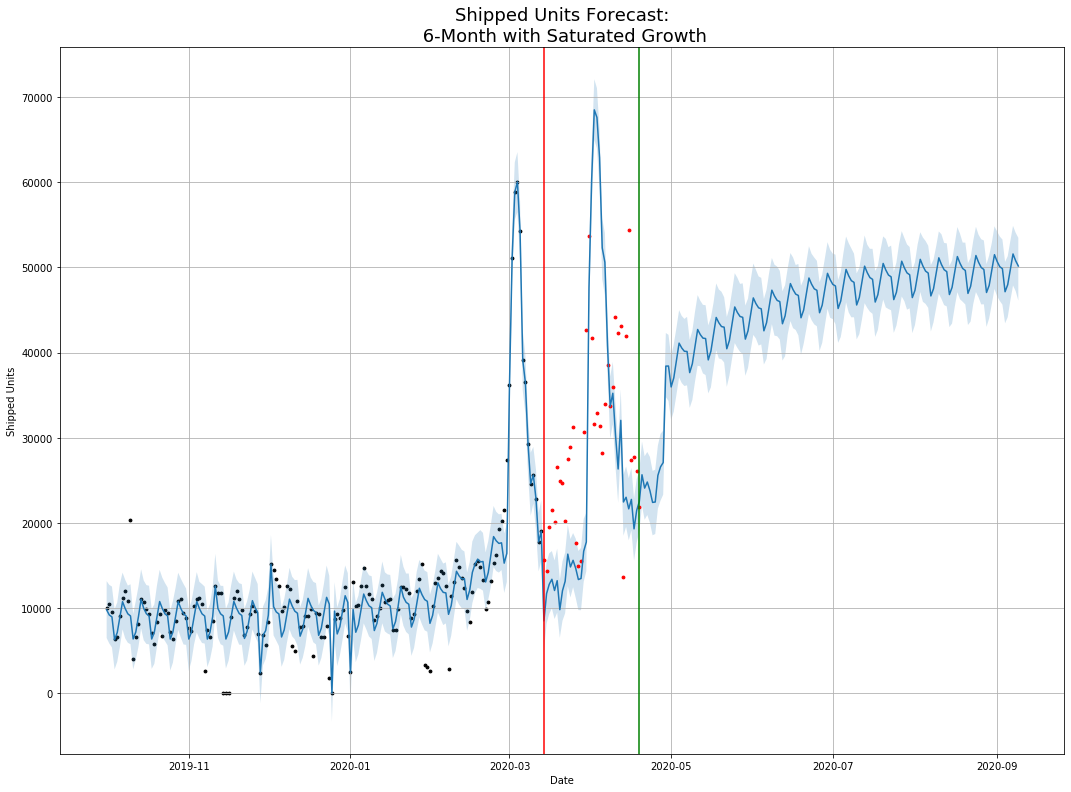

In [17]:
ar.view_predictions2(lhs_train, lhs_test, preds, start=len_of_train, title='6-Month with Saturated Growth')

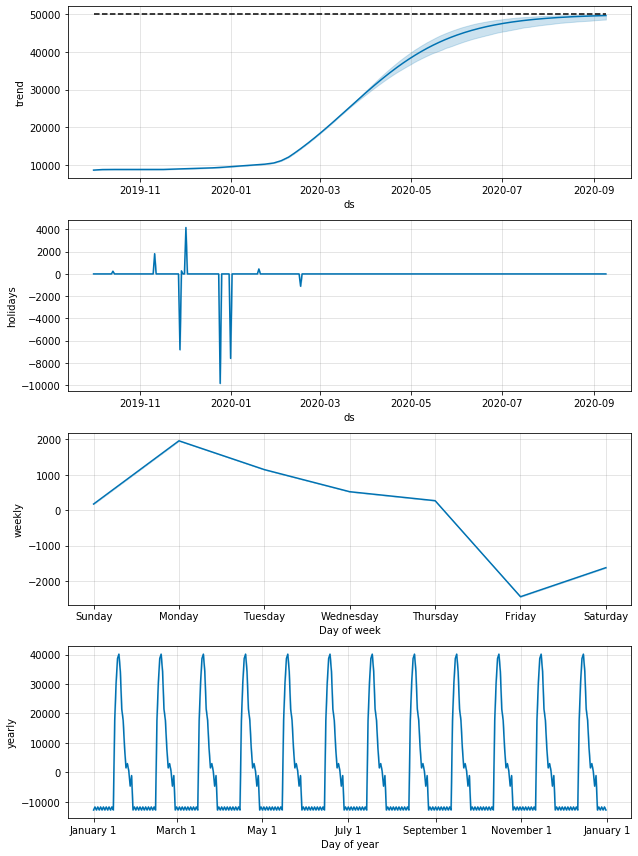

In [18]:
fig = ar.view_compoments(preds, model)

In [19]:
model_metrics_1 = ar.return_model_accuracy(preds, lhs_train)

In [20]:
model_1_forecast = preds.loc[len_of_train:,['ds', 'yhat']]

In [21]:
forecast_ts = model_1_forecast.set_index('ds')
forecast_monthly_1 = forecast_ts.resample('M').sum()

In [22]:
def suppress_sci_not(y):
    return round(y, 2)

In [23]:
forecast_monthly_1['yhat'] = forecast_monthly_1.yhat.apply(suppress_sci_not)
forecast_monthly_1.rename(columns={'yhat': 'shipped_units_forecast'}, inplace=True)
forecast_monthly_1

,shipped_units_forecast
ds,
2020-03-31,276805.08
2020-04-30,1012864.52
2020-05-31,1286661.04
2020-06-30,1386215.99
2020-07-31,1495141.35
2020-08-31,1528067.45
2020-09-30,448067.49


### Model 2: Added Regressor

In [24]:
covid_df_1 = pd.read_csv('./new-covid-cases-per-million (1).csv')
covid_df_2 = covid_df_1[covid_df_1['Entity'] == 'United States']

In [25]:
covid_df_2.rename(columns={'Entity': 'country', 'Code': 'code', 'Date': 'ds', 
                  'Daily new confirmed cases of COVID-19 per million people (cases)': 'infection_rate'}, inplace=True)

In [26]:
covid_df_2['ds'] = pd.to_datetime(covid_df_2.ds)
covid_df_2 = covid_df_2.loc[:, ['ds', 'infection_rate']]
covid_df_2.reset_index(inplace=True, drop=True)

In [27]:
lhs_daily_added_reg = pd.merge(lhs_daily, covid_df_2, on='ds', how='outer')
lhs_daily_added_reg.fillna(0, inplace=True)

### Train/Test Split

In [28]:
lhs_train_X = lhs_daily_added_reg[0:165]
print(lhs_train_X.shape)

lhs_test_X = lhs_daily_added_reg[165:]
print(lhs_test_X.shape)

(165, 3)
(37, 3)


In [29]:
preds_2, model_2 = ar.forecast_data(lhs_train_X, holidays_df, dates, added_regressor=True, added_reg_name='infection_rate')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


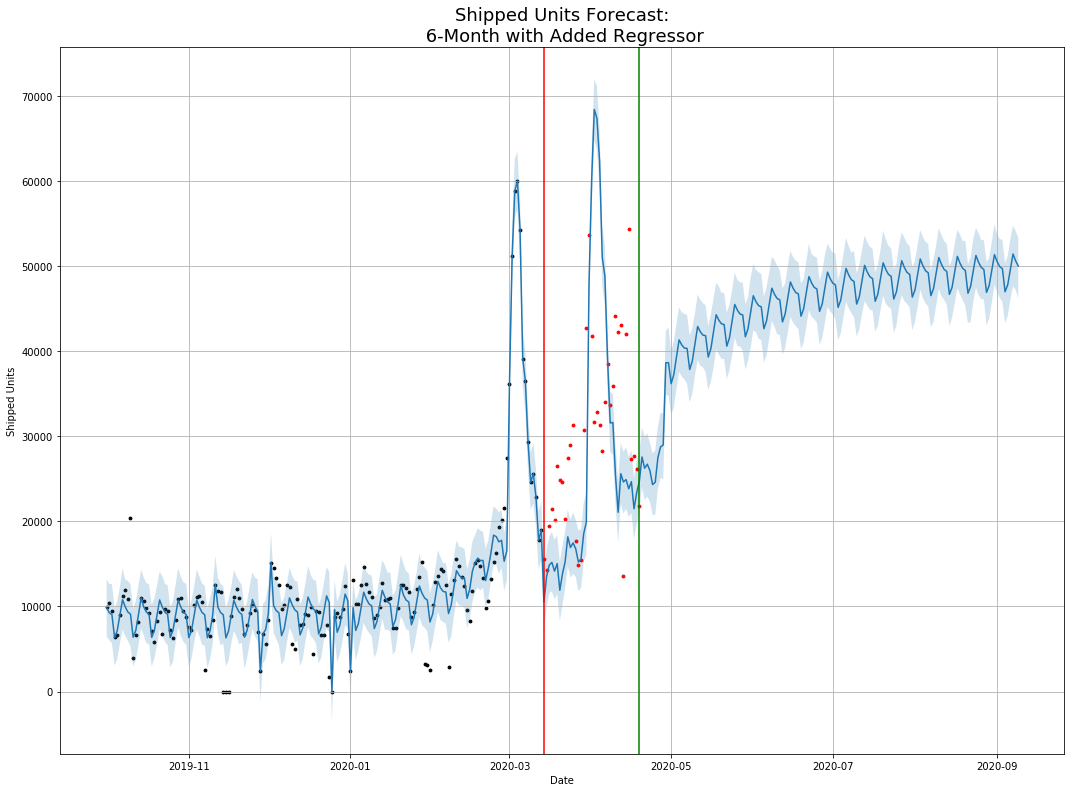

In [30]:
ar.view_predictions2(lhs_train_X, lhs_test_X, preds_2, start=len_of_train, title='6-Month with Added Regressor')

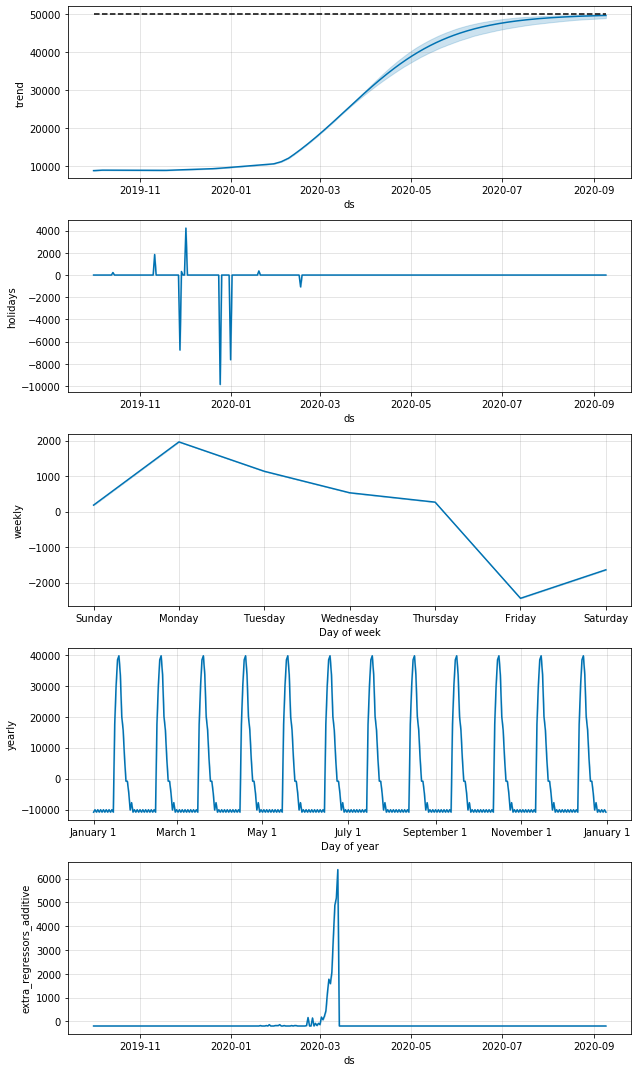

In [31]:
fig = ar.view_compoments(preds_2, model_2)

In [32]:
model_metrics_2 = ar.return_model_accuracy(preds_2, lhs_train_X)

In [33]:
model_2_forecast = preds_2.loc[len_of_train:,['ds', 'yhat']]

In [34]:
forecast_ts = model_2_forecast.set_index('ds')
forecast_monthly_2 = forecast_ts.resample('M').sum()

In [35]:
forecast_monthly_2['yhat'] = forecast_monthly_2.yhat.apply(suppress_sci_not)
forecast_monthly_2.rename(columns={'yhat': 'shipped_units_forecast'}, inplace=True)
forecast_monthly_2

,shipped_units_forecast
ds,
2020-03-31,310629.52
2020-04-30,1018212.79
2020-05-31,1292181.30
2020-06-30,1387677.15
2020-07-31,1493379.56
2020-08-31,1524269.39
2020-09-30,446733.23


In [36]:
metric_df = pd.DataFrame({'model_1': model_metrics_1, 
                          'model_2': model_metrics_2},
                        index=['rsme', 'r2', 'mae', 'mse'])

In [37]:
metric_df = metric_df.apply(suppress_sci_not)

In [38]:
metric_df

,model_1,model_2
rsme,2724.76,2717.25
r2,0.91,0.91
mae,1716.33,1713.77
mse,7424293.62,7383439.05
